In [18]:
import pandas as pd
from matplotlib import pyplot as plt
from lifelines import CoxPHFitter
import numpy as np
from lifelines import KaplanMeierFitter
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

In [33]:
df = pd.read_csv('../../data/relationships/relations_minified_versioning.csv')
# Remove rows with any NaN values
df = df.dropna()

# Remove dependencies that have the same start and end dates
df = df[df['interval_start_days'] != df['interval_end_days']]
## Data Preprocessing
df['is_out_of_date'] = df['is_out_of_date'].map({'t': True, 'f': False})
df['is_exposed'] = df['is_exposed'].map({'t': True, 'f': False})
df['interval_start_days'] = pd.to_numeric(df['interval_start_days'], errors='coerce')
df = df.dropna(subset=['interval_start_days'])
df['interval_end_days'] = pd.to_numeric(df['interval_end_days'], errors='coerce') ##coerce the errors to drop /N (NA) value in data
df = df.dropna(subset=['interval_end_days'])

df.dtypes

df.head

df.requirement_type.unique()

array(['floating-minor', 'floating-patch', 'fixed-ranging',
       'floating-major', 'pinning', 'complex-expression', 'at-most',
       'or-expression', 'not-expression'], dtype=object)

In [35]:
df.head()

,dependency_id,dependency_key,interval_start_days,interval_end_days,requirement_type,is_out_of_date,is_exposed
1,179696,CARGO|ab_glyph|ab_glyph_rasterizer,1078,1239.0,floating-minor,False,False
2,179696,CARGO|ab_glyph|ab_glyph_rasterizer,70,77.0,floating-minor,False,False
3,179696,CARGO|ab_glyph|ab_glyph_rasterizer,1001,1078.0,floating-minor,False,False
4,179696,CARGO|ab_glyph|ab_glyph_rasterizer,862,896.0,floating-minor,False,False
5,179696,CARGO|ab_glyph|ab_glyph_rasterizer,0,6.0,floating-minor,False,False


In [36]:
floating_major_check = df[df['requirement_type'] == 'floating-major']

print("=== Checking for floating_major requirement type ===")
print(f"Total observations with floating_major: {len(floating_major_check):,}")

if len(floating_major_check) > 0:
    # Count exposures among floating_major
    floating_major_exposed = floating_major_check[floating_major_check['is_exposed'] == True]
    
    print(f"Exposures when requirement_type = floating_major: {len(floating_major_exposed)}")
    
    # Calculate exposure rate
    exposure_rate = len(floating_major_exposed) / len(floating_major_check) * 100
    print(f"Exposure rate for floating_major: {exposure_rate:.3f}%")
    
    # Show some examples if they exist
    if len(floating_major_exposed) > 0:
        print(f"\nFirst few floating_major exposures:")
        print(floating_major_exposed[['dependency_id', 'requirement_type', 'is_exposed']].head())
else:
    print("No observations with requirement_type = 'floating_major' found")


=== Checking for floating_major requirement type ===
Total observations with floating_major: 293,759
Exposures when requirement_type = floating_major: 0
Exposure rate for floating_major: 0.000%


In [37]:
# Check which requirement types have both types of events
print("=== Requirement types with both is_exposed and is_outdated events ===\n")

# Get counts for each requirement type
req_summary = df.groupby('requirement_type').agg({
    'is_exposed': ['count', 'sum'],
    'is_out_of_date': ['count', 'sum']
}).round(3)

# Flatten column names
req_summary.columns = ['total_obs', 'exposed_events', 'total_obs2', 'outdated_events']
req_summary = req_summary.drop('total_obs2', axis=1)  # Remove duplicate

# Add event rates
req_summary['exposed_rate%'] = (req_summary['exposed_events'] / req_summary['total_obs'] * 100).round(3)
req_summary['outdated_rate%'] = (req_summary['outdated_events'] / req_summary['total_obs'] * 100).round(3)

# Filter to only requirement types with BOTH types of events
both_events = req_summary[(req_summary['exposed_events'] > 0) & (req_summary['outdated_events'] > 0)]

print("Requirement types with BOTH exposed AND outdated events:")
print("=" * 80)
print(both_events.sort_values('exposed_events', ascending=False))

print(f"\n📊 SUMMARY:")
print(f"Total requirement types: {len(req_summary)}")
print(f"Types with exposed events: {(req_summary['exposed_events'] > 0).sum()}")
print(f"Types with outdated events: {(req_summary['outdated_events'] > 0).sum()}")
print(f"Types with BOTH events: {len(both_events)}")

=== Requirement types with both is_exposed and is_outdated events ===

Requirement types with BOTH exposed AND outdated events:
                    total_obs  exposed_events  outdated_events  exposed_rate%  \
requirement_type                                                                
floating-minor         761611             807           159032          0.106   
pinning                300015             793           138887          0.264   
fixed-ranging          105777             405            22819          0.383   
floating-patch          72604             246            21707          0.339   
at-most                  4542             120             1924          2.642   
complex-expression       7908              51              849          0.645   
not-expression           1102               1               22          0.091   

                    outdated_rate%  
requirement_type                    
floating-minor              20.881  
pinning                     46.

In [8]:
# Sorting has effect on the model since the model expects the data for each individual together
df.sort_values(by=['dependency_id', 'interval_start_days', 'interval_end_days'], inplace=True)
print(df)
print(df.requirement_type.unique())

         dependency_id                     dependency_key  \
1283874            723                PYPI|cirq|cirq-ionq   
1284612            723                PYPI|cirq|cirq-ionq   
1285234            723                PYPI|cirq|cirq-ionq   
1285671            723                PYPI|cirq|cirq-ionq   
1284393            723                PYPI|cirq|cirq-ionq   
...                ...                                ...   
1205559        1559737       CARGO|icu_datagen|num-bigint   
1205574        1559738                   NPM|svelte|tslib   
1425875        1559739           PYPI|nevergrad|py-bobyqa   
1170039        1559741            NPM|yarn|imports-loader   
1205571        1559743  NPM|react-datepicker|react-docgen   

         interval_start_days  interval_end_days requirement_type  \
1283874                    0                0.0          pinning   
1284612                    0                0.0          pinning   
1285234                    0                0.0          pinnin

## Visualizing the Dependency Requirement Types

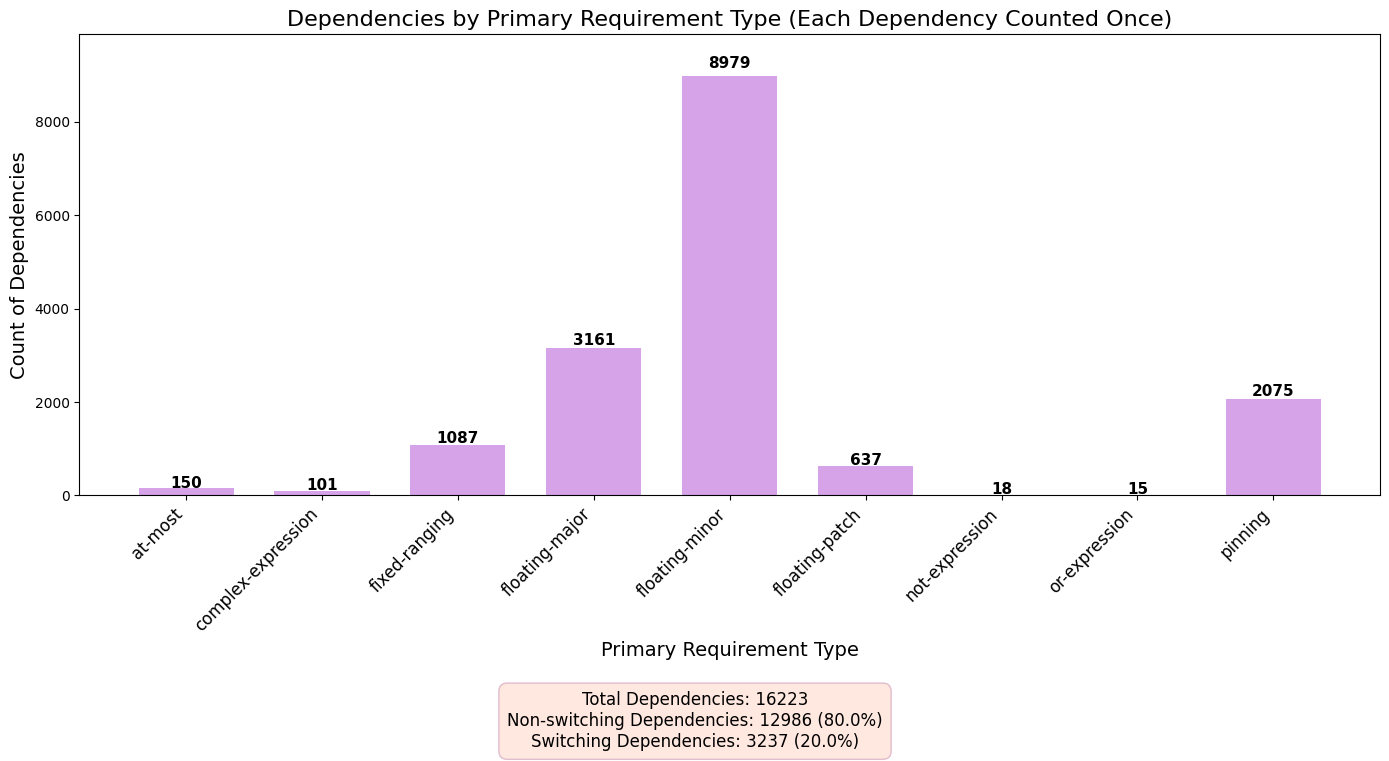

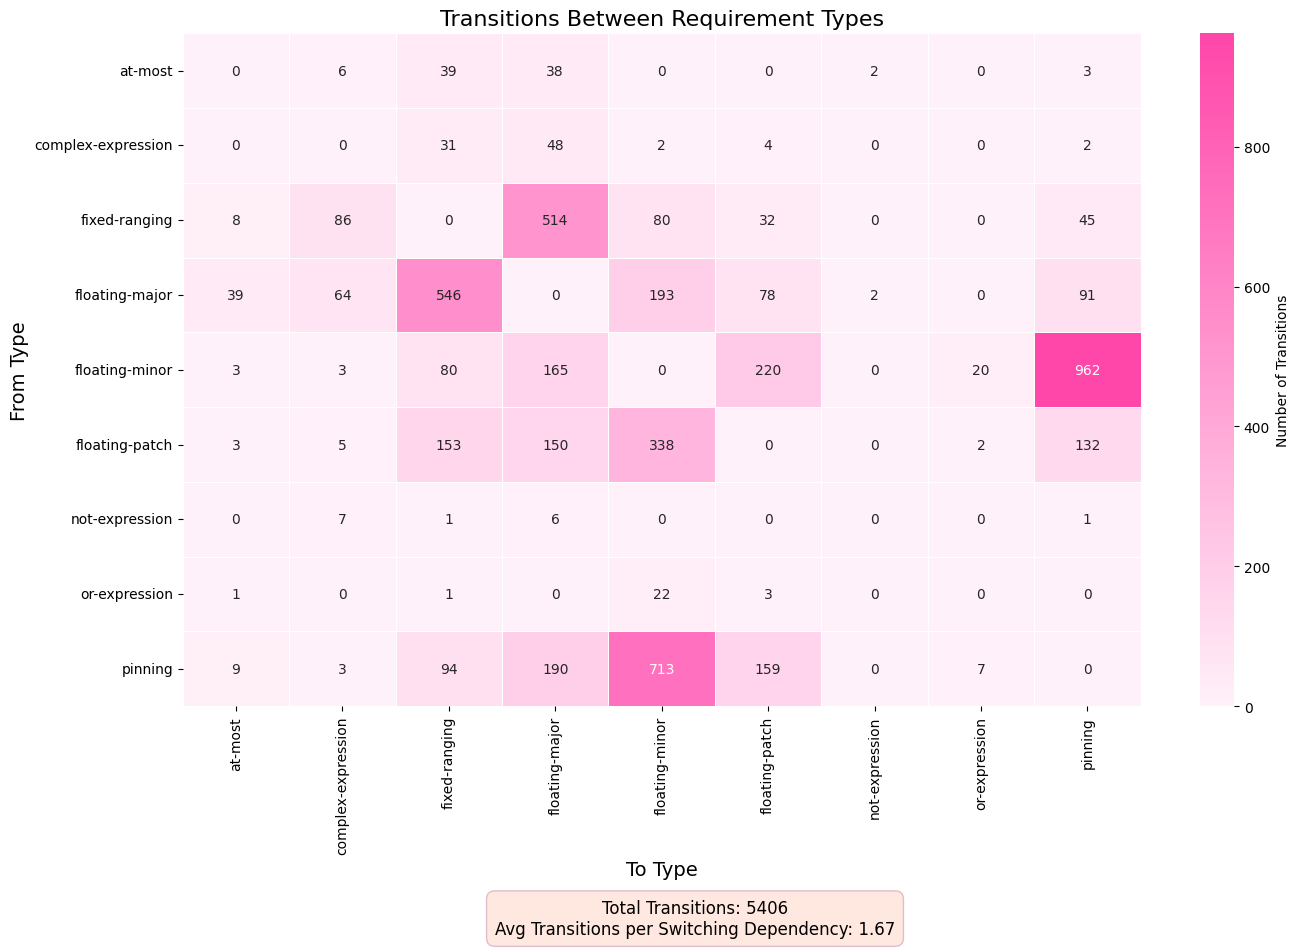

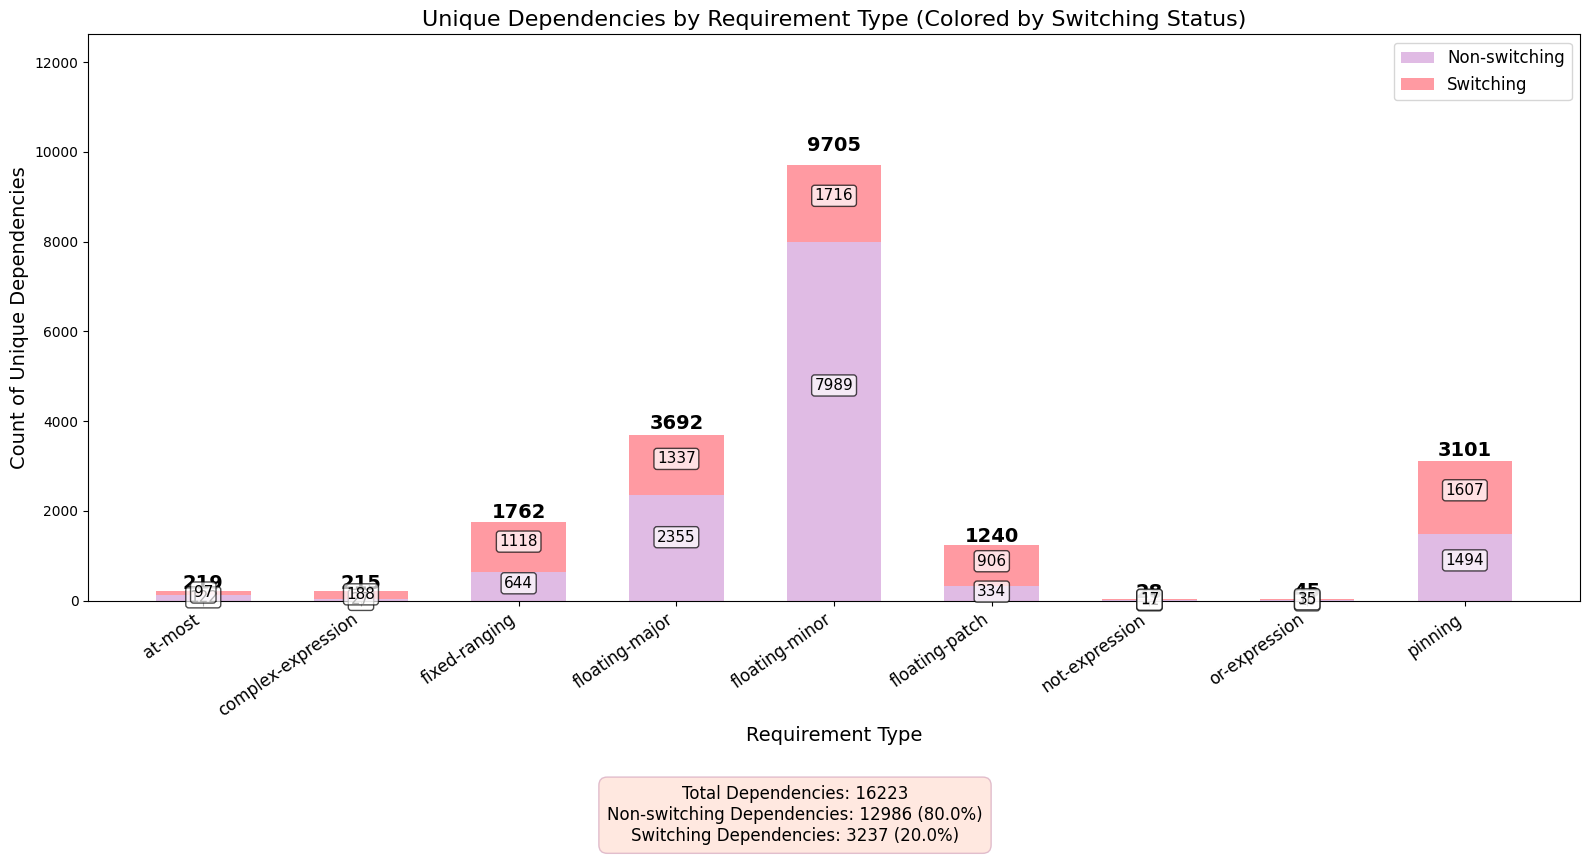

In [9]:
# Assuming df is already loaded with your data

# Part 1: Find dependencies that switch between requirement types
# Group by dependency_id and count unique requirement types
dependency_switches = df.groupby('dependency_id')['requirement_type'].nunique()
# Filter for dependencies with more than 1 requirement type
switching_deps = dependency_switches[dependency_switches > 1]
non_switching_deps = dependency_switches[dependency_switches == 1]

# Get the primary requirement type for each dependency (most common or first)
# For exclusive counts, we'll use the most frequent requirement type for each dependency
req_type_by_dep = df.groupby(['dependency_id', 'requirement_type']).size().reset_index(name='count')
primary_req_type = req_type_by_dep.sort_values(['dependency_id', 'count'], ascending=[True, False]) \
                                 .drop_duplicates('dependency_id')

# Count dependencies by their primary requirement type
exclusive_counts = primary_req_type.groupby('requirement_type').size()

# Create a DataFrame to track switching patterns
switching_patterns = pd.DataFrame(columns=['dependency_id', 'from_type', 'to_type', 'count'])

# For each switching dependency, find the transition patterns
rows = []
for dep_id in switching_deps.index:
    dep_data = df[df['dependency_id'] == dep_id]
    # Get the sequence of requirement types for this dependency
    req_sequence = dep_data['requirement_type'].tolist()
    
    # Track transitions between consecutive requirement types
    for i in range(len(req_sequence) - 1):
        from_type = req_sequence[i]
        to_type = req_sequence[i + 1]
        if from_type != to_type:  # Only count actual transitions
            rows.append({
                'dependency_id': dep_id,
                'from_type': from_type,
                'to_type': to_type,
                'count': 1
            })

if rows:
    switching_patterns = pd.DataFrame(rows)
    # Aggregate counts for same type transitions
    switching_patterns = switching_patterns.groupby(['from_type', 'to_type']).sum().reset_index()

# PLOT 1: Exclusive counts (each dependency counted only once)
plt.figure(figsize=(14, 8))

# Create a pretty pink color palette
exclusive_color = '#D6A2E8'  # Light purple

bars = plt.bar(exclusive_counts.index, exclusive_counts.values, color=exclusive_color, width=0.7)

plt.title('Dependencies by Primary Requirement Type (Each Dependency Counted Once)', fontsize=16)
plt.xlabel('Primary Requirement Type', fontsize=14)
plt.ylabel('Count of Dependencies', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.ylim(0, max(exclusive_counts.values) * 1.1)  # Add more space at the top

# Add the count values on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (height * 0.02) + 5,
            f'{int(height)}', ha='center', fontsize=11, fontweight='bold')

# Add information about switching dependencies
plt.figtext(0.5, 0.01, 
            f'Total Dependencies: {len(dependency_switches)}\n'
            f'Non-switching Dependencies: {len(non_switching_deps)} ({len(non_switching_deps)/len(dependency_switches)*100:.1f}%)\n'
            f'Switching Dependencies: {len(switching_deps)} ({len(switching_deps)/len(dependency_switches)*100:.1f}%)', 
            ha='center', fontsize=12, bbox=dict(facecolor='#FFDFD3', alpha=0.7, boxstyle='round,pad=0.5', edgecolor='#D5A6BD'))

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()

# PLOT 2: Transitions between requirement types with colored segments
if rows:
    # Create a pivot table for the heatmap
    pivot_data = switching_patterns.pivot_table(
        index='from_type', 
        columns='to_type', 
        values='count', 
        fill_value=0
    )
    
    plt.figure(figsize=(14, 10))
    
    # Custom pink colormap
    colors = ["#FFF1F9", "#FFDBEF", "#FFC6E5", "#FFB0DB", "#FF9AD1", "#FF85C7", "#FF70BD", "#FF5BB3", "#FF46A9"]
    cmap = LinearSegmentedColormap.from_list("pretty_pinks", colors)
    
    # Plot the heatmap with improved annotations
    ax = sns.heatmap(pivot_data, annot=True, cmap=cmap, fmt='g', linewidths=0.5,
                cbar_kws={'label': 'Number of Transitions'})
    
    # Improve the appearance
    plt.title('Transitions Between Requirement Types', fontsize=16)
    plt.xlabel('To Type', fontsize=14)
    plt.ylabel('From Type', fontsize=14)
    
    # Add legend for switching dependencies with prettier box
    total_transitions = switching_patterns['count'].sum()
    plt.figtext(0.5, 0.01, 
                f'Total Transitions: {total_transitions}\n'
                f'Avg Transitions per Switching Dependency: {total_transitions/len(switching_deps):.2f}', 
                ha='center', fontsize=12, bbox=dict(facecolor='#FFDFD3', alpha=0.7, boxstyle='round,pad=0.5', edgecolor='#D5A6BD'))
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

# PLOT 3: Requirement type distribution colored by switching vs non-switching
# Get counts by requirement type for switching and non-switching dependencies
switching_ids = switching_deps.index.tolist()

# Create a new dataframe with dependency_id and switching status
dep_status = pd.DataFrame({
    'dependency_id': dependency_switches.index,
    'is_switching': [dep_id in switching_ids for dep_id in dependency_switches.index]
})

# Merge with the original data
df_with_status = pd.merge(df, dep_status, on='dependency_id')

# Now count unique dependencies by requirement type and switching status
switching_status_counts = df_with_status.drop_duplicates(['dependency_id', 'requirement_type']) \
                                       .groupby(['requirement_type', 'is_switching']).size() \
                                       .unstack(fill_value=0)

# Reset index to make requirement_type a column
if isinstance(switching_status_counts, pd.Series):
    # Handle case where only one switching status exists
    switching_status_counts = pd.DataFrame(switching_status_counts)
else:
    switching_status_counts = switching_status_counts.reset_index()

# Rename columns for clarity
if True in switching_status_counts.columns:
    switching_status_counts = switching_status_counts.rename(columns={True: 'Switching', False: 'Non-switching'})
elif 'is_switching' in switching_status_counts.columns:
    switching_status_counts = switching_status_counts.rename(columns={'is_switching': 'Switching'})
    switching_status_counts['Non-switching'] = 0

# Fill NaN with zeros
switching_status_counts = switching_status_counts.fillna(0)

# Create the stacked bar chart
plt.figure(figsize=(16, 9))
width = 0.6  # Narrower bars for more space between them

# Create a pretty pink color palette
non_switching_color = '#E0BBE4'  # Light lavender
switching_color = '#FF9AA2'     # Light pink

# Get the requirement types and values
if 'requirement_type' in switching_status_counts.columns:
    req_types = switching_status_counts['requirement_type']
    non_switching_values = switching_status_counts['Non-switching'] if 'Non-switching' in switching_status_counts.columns else 0
    switching_values = switching_status_counts['Switching'] if 'Switching' in switching_status_counts.columns else 0
else:
    # Handle multiindex case
    req_types = switching_status_counts.index
    non_switching_values = switching_status_counts[False] if False in switching_status_counts.columns else 0
    switching_values = switching_status_counts[True] if True in switching_status_counts.columns else 0

# Draw the stacked bars
plt.bar(req_types, non_switching_values, width, label='Non-switching', color=non_switching_color)
plt.bar(req_types, switching_values, width, bottom=non_switching_values, label='Switching', color=switching_color)

# Create custom annotations
for i, req_type in enumerate(req_types):
    non_switch = non_switching_values.iloc[i] if hasattr(non_switching_values, 'iloc') else non_switching_values[i]
    switch = switching_values.iloc[i] if hasattr(switching_values, 'iloc') else switching_values[i]
    total = non_switch + switch
    
    # Special handling for the problematic bar (floating-major-restrictive)
    if 'restrictive' in str(req_type):
        # Place the total high above
        plt.text(i, total + 400, f'{int(total)}', ha='center', fontsize=14, fontweight='bold')
        
###############################################################  
# editing the spacing around the arrows       
        # Create annotation arrows for the segments to make them clear
        # For non-switching segment
        if non_switch > 0:
            # Place an annotation outside the bar with an arrow pointing to the segment
            plt.annotate(
                f'Non-switching: {int(non_switch)}',
                xy=(i, non_switch/2),  # Point in the middle of the segment
                xytext=(i - 0.4, non_switch/2),  # Text position 
                arrowprops=dict(arrowstyle="->", color='black'),
                fontsize=10,
                ha='right',
                va='center',
                bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='black', alpha=0.8)
            )
        
        # For switching segment
        if switch > 0:
            # Place an annotation outside the bar with an arrow pointing to the segment
            plt.annotate(
                f'Switching: {int(switch)}',
                xy=(i, non_switch + switch/2),  # Point in the middle of the segment
                xytext=(i + 0.4, non_switch + switch/2),  # Text position
                arrowprops=dict(arrowstyle="->", color='black'),
                fontsize=10,
                ha='left',
                va='center',
                bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='black', alpha=0.8)
            )

###############################################################  
    else:
        # Regular bars - place total above
        plt.text(i, total + (total * 0.03) + 30, f'{int(total)}', ha='center', fontsize=14, fontweight='bold')
        
        # Add counts in the middle of each segment if large enough
        if non_switch > total * 0.08:
            plt.text(i, non_switch * 0.6, f'{int(non_switch)}', ha='center', va='center', 
                     fontsize=11, color='black', bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'))
        
        if switch > total * 0.08:
            plt.text(i, non_switch + switch * 0.6, f'{int(switch)}', ha='center', va='center', 
                     fontsize=11, color='black', bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'))

plt.title('Unique Dependencies by Requirement Type (Colored by Switching Status)', fontsize=16)
plt.xlabel('Requirement Type', fontsize=14)
plt.ylabel('Count of Unique Dependencies', fontsize=14)
plt.xticks(rotation=35, ha='right', fontsize=12)
plt.ylim(0, max(non_switching_values + switching_values) * 1.3)  # Extra space for annotations

plt.legend(fontsize=12, loc='upper right')

# Add information about switching dependencies with a prettier box
plt.figtext(0.5, 0.01, 
            f'Total Dependencies: {len(dependency_switches)}\n'
            f'Non-switching Dependencies: {len(non_switching_deps)} ({len(non_switching_deps)/len(dependency_switches)*100:.1f}%)\n'
            f'Switching Dependencies: {len(switching_deps)} ({len(switching_deps)/len(dependency_switches)*100:.1f}%)', 
            ha='center', fontsize=12, bbox=dict(facecolor='#FFDFD3', alpha=0.7, boxstyle='round,pad=0.5', edgecolor='#D5A6BD'))

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()

## **Cox Proportional Hazards Model - Time Varying Covariates**


In [10]:
df = pd.read_csv('../../data/relationships/relations_minified_versioning.csv')

## Data Preprocessing
df['is_out_of_date'] = df['is_out_of_date'].map({'t': True, 'f': False})
df['is_exposed'] = df['is_exposed'].map({'t': True, 'f': False})
df['interval_start_days'] = pd.to_numeric(df['interval_start_days'], errors='coerce')
df = df.dropna(subset=['interval_start_days'])
df['interval_end_days'] = pd.to_numeric(df['interval_end_days'], errors='coerce') ##coerce the errors to drop /N (NA) value in data
df = df.dropna(subset=['interval_end_days'])

## must remove deependencies that have the start and end dates the same
df = df[df['interval_start_days'] != df['interval_end_days']]

df.dtypes

df.head

df.requirement_type.unique()

array(['floating-minor', 'floating-patch', 'fixed-ranging',
       'floating-major', 'pinning', 'complex-expression', 'at-most',
       'or-expression', 'not-expression'], dtype=object)

In [11]:
# Need to convert the requirement_type column to a categorical type

df['requirement_type'] = pd.Categorical(
    df['requirement_type'],
    categories=['floating-major', # This is the baseline for one-hot encoding
                'floating-minor',
                'floating-patch',
                'fixed-ranging',
                'pinning',
                'complex-expression',
                'at-most',
                'or-expression',
                'not-expression'
    ],
    ordered=True
)
df = pd.get_dummies(df, columns=['requirement_type'], drop_first=True)

# Sorting has effect on the model since the model expects the data for each individual together
df.sort_values(by=['dependency_id', 'interval_start_days', 'interval_end_days'], inplace=True)

In [12]:
df.dtypes

dependency_id                            int64
dependency_key                          object
interval_start_days                      int64
interval_end_days                      float64
is_out_of_date                            bool
is_exposed                                bool
requirement_type_floating-minor           bool
requirement_type_floating-patch           bool
requirement_type_fixed-ranging            bool
requirement_type_pinning                  bool
requirement_type_complex-expression       bool
requirement_type_at-most                  bool
requirement_type_or-expression            bool
requirement_type_not-expression           bool
dtype: object

## Cox Proportional Hazards Model - Outdated Dependencies

In [13]:
## only keep the variables we are interested in modeling 
columns_to_keep = ['dependency_id', 'interval_start_days', 'interval_end_days', 'is_out_of_date',
    'requirement_type_floating-minor',
    'requirement_type_floating-patch',
    'requirement_type_fixed-ranging',
    # 'requirement_type_floating-major',
    'requirement_type_pinning',
    'requirement_type_complex-expression',
    'requirement_type_at-most',
    'requirement_type_or-expression',
    'requirement_type_not-expression']
df_model_outdated = df[columns_to_keep]
df_model_outdated.head

<bound method NDFrame.head of          dependency_id  interval_start_days  interval_end_days  \
1284393            723                    0                1.0   
1284379            723                    1                2.0   
1284338            723                    2                3.0   
1285387            723                    3                6.0   
1284064            723                    6                7.0   
...                ...                  ...                ...   
1205572        1559735                    0                1.0   
1205559        1559737                    0               33.0   
1205574        1559738                    0                6.0   
1425875        1559739                    0               14.0   
1205571        1559743                    0                3.0   

         is_out_of_date  requirement_type_floating-minor  \
1284393           False                            False   
1284379           False                            False 

In [14]:
# verifying we kept the proper number of unique dependencies
print("Number of unique dependencies: ",df_model_outdated['dependency_id'].nunique())

Number of unique dependencies:  16094


## Testing for perfect separation

In [16]:
covariates = [
    'requirement_type_floating-minor',
    'requirement_type_floating-patch',
    'requirement_type_fixed-ranging',
    # 'requirement_type_floating-major',
    'requirement_type_pinning',
    'requirement_type_complex-expression',
    'requirement_type_at-most',
    'requirement_type_or-expression',
    'requirement_type_not-expression'
]

# Loop and print cross-tabs
for cov in covariates:
    print(f"\n=== Crosstab for: {cov} ===")
    ct = pd.crosstab(df[cov], df['is_out_of_date'])
    print(ct)


=== Crosstab for: requirement_type_floating-minor ===
is_out_of_date                    False   True 
requirement_type_floating-minor                
False                            507766  103135
True                             480009  116292

=== Crosstab for: requirement_type_floating-patch ===
is_out_of_date                    False   True 
requirement_type_floating-patch                
False                            943101  201292
True                              44674   18135

=== Crosstab for: requirement_type_fixed-ranging ===
is_out_of_date                   False   True 
requirement_type_fixed-ranging                
False                           914699  198825
True                             73076   20602

=== Crosstab for: requirement_type_pinning ===
is_out_of_date             False   True 
requirement_type_pinning                
False                     848720  159330
True                      139055   60097

=== Crosstab for: requirement_type_complex-expressi

### ✅ So: Is there perfect separation?
**No, there is not perfect separation, because:**

You do see both True and False in is_out_of_date for both values of 'requirement_type_not-expression'.

If it were perfect, you'd see all 969+20 either in just False or True.

### **requirement_type_not-expression == True AND is_out_of_date == True → only 20 rows out of 1.2M**

That's 0.0016% of the data — extremely sparse.

This sparsity can:

Lead to unstable coefficient estimation

Cause convergence issues or inflated hazard ratios

Trigger this warning even when there's no actual perfect separation


## Back to modeling

/Users/jillmarley/Desktop/update-metrics/myenv/lib/python3.12/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column requirement_type_not-expression have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['is_out_of_date'].astype(bool)
>>> print(df.loc[events, 'requirement_type_not-expression'].var())
>>> print(df.loc[~events, 'requirement_type_not-expression'].var())

A very low variance means that the column requirement_type_not-expression completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


<lifelines.CoxTimeVaryingFitter: fitted with 1207202 periods, 16094 subjects, 219427 events>
         event col = 'is_out_of_date'
number of subjects = 16094
 number of periods = 1207202
  number of events = 219427
partial log-likelihood = -1888735.72
  time fit was run = 2025-05-26 14:54:10 UTC

---
                                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                            
requirement_type_floating-minor      4.05     57.40      0.04            3.98            4.12               53.49               61.59
requirement_type_floating-patch      4.59     98.36      0.04            4.52            4.66               91.56              105.68
requirement_type_fixed-ranging       4.39     80.52      0.04            4.32            4.46               74.96               86.49
requirement_type_pinning             4.87    130.72      0.04            4.80            4.94              121.80              140.29
requirement_type_complex-expression  3.44     31.31      0.05            3.35            3.54               28.36               34.56
requirement_type_at-most             4.87    130.89      0.04            4.79            4.96              120.29              142.43
requirement_type_or-expression       5.53    253.03      0.05            5.44            5.63              230.20              278.14
requirement_type_not-expression      1.59      4.92      0.23            1.15            2.04                3.15                7.66

                                     cmp to      z      p  -log2(p)
covariate                                                          
requirement_type_floating-minor        0.00 112.66 <0.005       inf
requirement_type_floating-patch        0.00 125.39 <0.005       inf
requirement_type_fixed-ranging         0.00 120.23 <0.005       inf
requirement_type_pinning               0.00 135.13 <0.005       inf
requirement_type_complex-expression    0.00  68.27 <0.005       inf
requirement_type_at-most               0.00 113.11 <0.005       inf
requirement_type_or-expression         0.00 114.65 <0.005       inf
requirement_type_not-expression        0.00   7.03 <0.005     38.83
---
Partial AIC = 3777487.43
log-likelihood ratio test = 122215.40 on 8 df
-log2(p) of ll-ratio test = inf

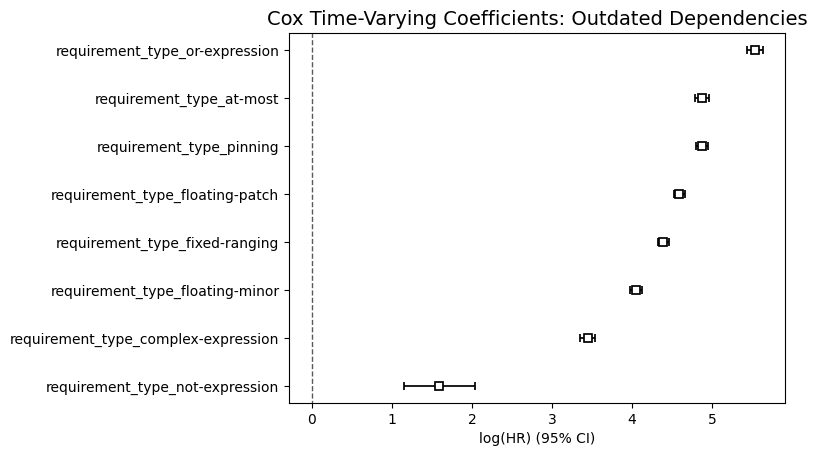

In [18]:
from lifelines import CoxTimeVaryingFitter

ctv = CoxTimeVaryingFitter()
ctv.fit(df_model_outdated, id_col="dependency_id", event_col="is_out_of_date", start_col="interval_start_days", stop_col="interval_end_days")
ctv.print_summary()

# Plot and set title
ax = ctv.plot()
ax.set_title("Cox Time-Varying Coefficients: Outdated Dependencies", fontsize=14)
plt.show()

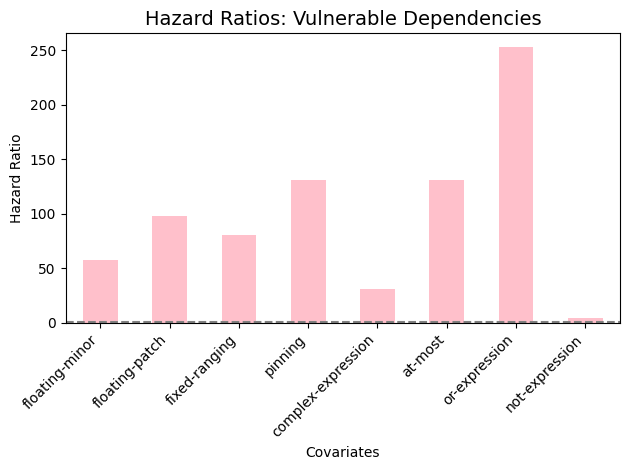

In [19]:
# Define your renaming dictionary
rename_map = {
    'requirement_type_floating-minor': 'floating-minor',
    'requirement_type_floating-patch': 'floating-patch',
    'requirement_type_fixed-ranging': 'fixed-ranging',
    'requirement_type_floating-major': 'floating-major',
    'requirement_type_pinning': 'pinning',
    'requirement_type_complex-expression': 'complex-expression',
    'requirement_type_at-most': 'at-most',
    'requirement_type_or-expression': 'or-expression',
    'requirement_type_not-expression': 'not-expression',
}

# Get hazard ratios
hazard_ratios = np.exp(ctv.params_)

# Plot hazard ratios
ax = hazard_ratios.plot(kind='bar', color = 'pink')

# Apply renaming just to x-axis labels
new_labels = [rename_map.get(label, label) for label in hazard_ratios.index]
ax.set_xticklabels(new_labels, rotation=45, ha='right')

# Set plot details
ax.set_title("Hazard Ratios: Vulnerable Dependencies", fontsize=14)
ax.set_ylabel("Hazard Ratio")
ax.set_xlabel("Covariates")
plt.axhline(y=1, color='grey', linestyle='--')
plt.tight_layout()
plt.show()

# Interpretation

*Please note that this interpretation came from AI and we need to rephrase in our words before publishing*

This Cox proportional hazards model examines when software dependencies become outdated, with 17,504 subjects and over 1.2 million observation periods. The outcome "is_out_of_date" indicates when dependencies become outdated.

### Note on hazard ratio:
Values > 1: higher risk of the event (becoming out-of-date).

**Example:** At any given time, if a dependency is currently under a `"pinned"` requirement, its hazard of becoming out-of-date is approximately **91× higher** than the baseline.  
These hazard ratios represent the **relative risk at that time**, conditional on the dependency’s current requirement type.


### Hazard Ratios (exp(coef)) Compared to Baseline (requirement_type_floating - major)

*These hazard ratios come from a **Cox Time-Varying Proportional Hazards model**, where the **type of requirement can change over time**. The values below represent the **relative instantaneous risk** of a dependency becoming exposed **when it is in a given state**, compared to the baseline.*

requirement_type_floating - major - restrictive: 39.641(3964% higher risk than baseline) 

requirement_type_floating - minor: 38.21 (3821% higher risk)  

requirement_type_floating - patch: 65.17 (6517% higher risk)  

requirement_type_pinned: 91.37 (9137% higher risk)  

requirement_type_other: 86.77 (8677% higher risk) 

### Interpretation of Hazard Ratios
These extremely high hazard ratios indicate:

requirement_type_pinned has by far the highest risk, with dependencies nearly 91 times more likely to become outdated compared to floating major requirements.

requirement_type_floating - patch has the second-highest risk, with dependencies about 65 times more likely to become outdated.

requirement_type_floating - major - restrictive and requirement_type_floating - minor have similar elevated risks (about 39 and 38 times higher, respectively).

Even requirement_type_other shows a substantially higher risk (~87 times) compared to the baseline.

### Statistical Significance
All results are highly statistically significant (p < 0.005) with extremely large z-values (>100). The narrow confidence intervals indicate high precision in these estimates. The log-likelihood ratio test (122,616.75 on 5 df) confirms the model as a whole is extremely significant.

### Practical Implications
These results strongly suggest that compared to floating major version requirements:

Pinned dependencies become outdated at a dramatically faster rate.

This suggests that if maintaining up-to-date dependencies is important, using floating major version requirements (the baseline) appears to be the optimal strategy, as all other requirement types show significantly higher risks of becoming outdated.

```text
Pinned                       | ████████████████████████████████████████████████████████████████████ (HR ≈ 91.37)
Floating - Patch             | ██████████████████████████████████████████████████ (HR ≈ 65.17)
Floating - Major - Restrict  | ████████████████████████████████ (HR ≈ 39.61)
Floating - Minor             | ████████████████████████████ (HR ≈ 38.21)
```

## Cox Proportional Hazards Model - Vulnerable Dependencies

In [32]:
## only keep the variables we are interested in modeling 
# columns_to_keep = ['dependency_id', 'interval_start_days', 'interval_end_days', 'is_exposed', 'requirement_type_floating - major - restrictive', 'requirement_type_floating - minor', 'requirement_type_floating - patch', 'requirement_type_pinned', 'requirement_type_other']
# df_model_vulnerable = df[columns_to_keep]
# df_model_vulnerable.head

## only keep the variables we are interested in modeling 
columns_to_keep = ['dependency_id', 'interval_start_days', 'interval_end_days', 'is_exposed', 'requirement_type_floating-minor',
    'requirement_type_floating-patch',
    'requirement_type_fixed-ranging',
    # 'requirement_type_floating-major',
    'requirement_type_pinning',
    'requirement_type_complex-expression',
    'requirement_type_at-most',
    'requirement_type_or-expression',
    'requirement_type_not-expression']
df_model_vuln = df[columns_to_keep]
df_model_vuln.head

<bound method NDFrame.head of          dependency_id  interval_start_days  interval_end_days  is_exposed  \
1284393            723                    0                1.0       False   
1284379            723                    1                2.0       False   
1284338            723                    2                3.0       False   
1285387            723                    3                6.0       False   
1284064            723                    6                7.0       False   
...                ...                  ...                ...         ...   
1205572        1559735                    0                1.0       False   
1205559        1559737                    0               33.0       False   
1205574        1559738                    0                6.0       False   
1425875        1559739                    0               14.0       False   
1205571        1559743                    0                3.0       False   

         requirement_type_floatin

In [42]:
df_model_vuln.dtypes


dependency_id                            int64
interval_start_days                      int64
interval_end_days                      float64
is_exposed                                bool
requirement_type_floating-minor           bool
requirement_type_floating-patch           bool
requirement_type_fixed-ranging            bool
requirement_type_pinning                  bool
requirement_type_complex-expression       bool
requirement_type_at-most                  bool
requirement_type_or-expression            bool
requirement_type_not-expression           bool
dtype: object

In [35]:
# verifying we kept the proper number of unique dependencies
print("Number of unique dependencies: ",df_model_vuln['dependency_id'].nunique())
print("Number of dependencies that are vulnerable: ",df_model_vuln['is_exposed'].sum())

Number of unique dependencies:  16094
Number of dependencies that are vulnerable:  1931


In [36]:
df_model_vuln.head

<bound method NDFrame.head of          dependency_id  interval_start_days  interval_end_days  is_exposed  \
1284393            723                    0                1.0       False   
1284379            723                    1                2.0       False   
1284338            723                    2                3.0       False   
1285387            723                    3                6.0       False   
1284064            723                    6                7.0       False   
...                ...                  ...                ...         ...   
1205572        1559735                    0                1.0       False   
1205559        1559737                    0               33.0       False   
1205574        1559738                    0                6.0       False   
1425875        1559739                    0               14.0       False   
1205571        1559743                    0                3.0       False   

         requirement_type_floatin

In [44]:
events = df_model_vuln['is_exposed'].astype(bool)
print(df_model_vuln.loc[events, 'requirement_type_or-expression'].var())
print(df_model_vuln.loc[~events, 'requirement_type_or-expression'].var())

pd.crosstab(df_model_vuln['requirement_type_or-expression'], df_model_vuln['is_exposed'])

0.0
0.001890593466594192


is_exposed,False,True
requirement_type_or-expression,,
False,1202988,1931
True,2283,0


### When requirement_type_or-expression == True, there are zero exposed events (is_exposed == True)

In [46]:
pd.crosstab(df_model_vuln['requirement_type_not-expression'], df_model_vuln['is_exposed'])

is_exposed,False,True
requirement_type_not-expression,,
False,1204283,1930
True,988,1


### When requirement_type_not-expression == True, there is ONE exposed event (is_exposed == True)

In [51]:
# Select a subset of variables
cols_to_keep = ['dependency_id', 'interval_start_days', 'interval_end_days', 'is_exposed',
    'requirement_type_floating-minor',
    'requirement_type_floating-patch',
    'requirement_type_fixed-ranging',
    # 'requirement_type_floating-major',
    'requirement_type_pinning',
    'requirement_type_complex-expression',
    'requirement_type_at-most',
    # 'requirement_type_or-expression',
    'requirement_type_not-expression'
]

df_model_vul = df[cols_to_keep]

df_model_vul.head()


,dependency_id,interval_start_days,interval_end_days,is_exposed,requirement_type_floating-minor,requirement_type_floating-patch,requirement_type_fixed-ranging,requirement_type_pinning,requirement_type_complex-expression,requirement_type_at-most,requirement_type_not-expression
1284393,723,0,1.0,False,False,False,False,True,False,False,False
1284379,723,1,2.0,False,False,False,False,True,False,False,False
1284338,723,2,3.0,False,False,False,False,True,False,False,False
1285387,723,3,6.0,False,False,False,False,True,False,False,False
1284064,723,6,7.0,False,False,False,False,True,False,False,False


In [52]:
ctv = CoxTimeVaryingFitter()
ctv.fit(df_model_vul, id_col="dependency_id", event_col="is_exposed", 
       start_col="interval_start_days", stop_col="interval_end_days",
       show_progress=True)
ctv.print_summary()

# Plot and set title
ax = ctv.plot()
ax.set_title("Cox Time-Varying Coefficients: Vulnerable Dependencies", fontsize=14)
plt.show()

Iteration 1: norm_delta = 1.54e+00, step_size = 0.9500, log_lik = -17163.98801, newton_decrement = 1.64e+03, seconds_since_start = 7.0
Iteration 2: norm_delta = 1.60e+02, step_size = 0.9500, log_lik = -30036.05532, newton_decrement = 2.41e+06, seconds_since_start = 13.6


/Users/jillmarley/Desktop/update-metrics/myenv/lib/python3.12/site-packages/lifelines/fitters/cox_time_varying_fitter.py:526: RuntimeWarning: overflow encountered in exp
  phi_i = weights_at_t * np.exp(np.dot(X_at_t, beta))
/Users/jillmarley/Desktop/update-metrics/myenv/lib/python3.12/site-packages/lifelines/fitters/cox_time_varying_fitter.py:578: RuntimeWarning: invalid value encountered in multiply
  summand = numer * denom[:, None]
/Users/jillmarley/Desktop/update-metrics/myenv/lib/python3.12/site-packages/lifelines/fitters/cox_time_varying_fitter.py:582: RuntimeWarning: divide by zero encountered in log
  log_lik = log_lik + np.dot(x_death_sum, beta) + weighted_average * np.log(denom).sum()
/Users/jillmarley/Desktop/update-metrics/myenv/lib/python3.12/site-packages/lifelines/fitters/cox_time_varying_fitter.py:566: RuntimeWarning: invalid value encountered in multiply
  denom = 1.0 / (risk_phi - increasing_proportion * tie_phi)
/Users/jillmarley/Desktop/update-metrics/myenv/lib/pyth

ConvergenceError: hessian or gradient contains nan or inf value(s). Convergence halted. Please see the following tips in the lifelines documentation:
https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
array must not contain infs or NaNs

## Determining why there is a convergence issue

### Step 1: any na values?

In [53]:
print(df_model_vul[['interval_start_days', 'interval_end_days', 'is_exposed']].isna().sum())
print(df_model_vul[['interval_start_days', 'interval_end_days']].apply(lambda x: np.isinf(x).sum()))

# Check all covariates for NaNs/Infs
print(df_model_vul.isna().sum())
print(np.isinf(df_model_vul).sum())

interval_start_days    0
interval_end_days      0
is_exposed             0
dtype: int64
interval_start_days    0
interval_end_days      0
dtype: int64
dependency_id                          0
interval_start_days                    0
interval_end_days                      0
is_exposed                             0
requirement_type_floating-minor        0
requirement_type_floating-patch        0
requirement_type_fixed-ranging         0
requirement_type_pinning               0
requirement_type_complex-expression    0
requirement_type_at-most               0
requirement_type_not-expression        0
dtype: int64
dependency_id                          0
interval_start_days                    0
interval_end_days                      0
is_exposed                             0
requirement_type_floating-minor        0
requirement_type_floating-patch        0
requirement_type_fixed-ranging         0
requirement_type_pinning               0
requirement_type_complex-expression    0
requirement_type

### Step 2: Any invalid time intervals?

In [54]:
invalid_intervals = df_model_vul[df_model_vul['interval_end_days'] <= df_model_vul['interval_start_days']]
print(invalid_intervals)

# If any invalid intervals, fix or drop them:
df_model_vul_clean = df_model_vul[df_model_vul['interval_end_days'] > df_model_vul['interval_start_days']]

Empty DataFrame
Columns: [dependency_id, interval_start_days, interval_end_days, is_exposed, requirement_type_floating-minor, requirement_type_floating-patch, requirement_type_fixed-ranging, requirement_type_pinning, requirement_type_complex-expression, requirement_type_at-most, requirement_type_not-expression]
Index: []


### Step 3: Check the correlation matrix between covarietes 

In [64]:
# Get only the covariates (exclude ID, event, and time columns)
X = df_model_vul.drop(columns=[
    'dependency_id', 'is_exposed', 'interval_start_days', 'interval_end_days'
])

corr_matrix = X.corr().round(2)
print(corr_matrix)

                                     requirement_type_floating-minor  \
requirement_type_floating-minor                                 1.00   
requirement_type_floating-patch                                -0.23   
requirement_type_fixed-ranging                                 -0.29   
requirement_type_pinning                                       -0.44   
requirement_type_complex-expression                            -0.07   
requirement_type_at-most                                       -0.06   

                                     requirement_type_floating-patch  \
requirement_type_floating-minor                                -0.23   
requirement_type_floating-patch                                 1.00   
requirement_type_fixed-ranging                                 -0.07   
requirement_type_pinning                                       -0.10   
requirement_type_complex-expression                            -0.02   
requirement_type_at-most                                       

## ✅ Interpretation
**No pair of covariates is collinear or strongly correlated.**
Lifelines (and most regression models) start breaking down when correlations are |0.8| or higher.

The maximum absolute correlation here is 0.44, which is well below the threshold for concern.

### Step 4: Checking other covariates for perfect separation (which we know exists in or-expression and almost exists in not-expression)

In [58]:
covariates = [
    'requirement_type_floating-minor',
    'requirement_type_floating-patch',
    'requirement_type_fixed-ranging',
    # 'requirement_type_floating-major',
    'requirement_type_pinning',
    'requirement_type_complex-expression',
    'requirement_type_at-most',
    'requirement_type_or-expression',
    'requirement_type_not-expression'
]

# Loop and print cross-tabs
for cov in covariates:
    print(f"\n=== Crosstab for: {cov} ===")
    ct = pd.crosstab(df[cov], df['is_exposed'])
    print(ct)


=== Crosstab for: requirement_type_floating-minor ===
is_exposed                        False  True 
requirement_type_floating-minor               
False                            609617   1284
True                             595654    647

=== Crosstab for: requirement_type_floating-patch ===
is_exposed                         False  True 
requirement_type_floating-patch                
False                            1142617   1776
True                               62654    155

=== Crosstab for: requirement_type_fixed-ranging ===
is_exposed                        False  True 
requirement_type_fixed-ranging                
False                           1111974   1550
True                              93297    381

=== Crosstab for: requirement_type_pinning ===
is_exposed                  False  True 
requirement_type_pinning                
False                     1006703   1347
True                       198568    584

=== Crosstab for: requirement_type_complex-expression =

### Step 5: Checking for sparsity of covariates in data 

In [69]:
X = df.drop(columns=[
    'dependency_id', 'is_exposed', 'interval_start_days', 'interval_end_days', 'is_out_of_date'
])

# Count number of non-zero entries and calculate percentage
non_zero_counts = (X != 0).sum()
total_rows = X.shape[0]
non_zero_percent = (non_zero_counts / total_rows * 100).round(3)

# Combine in a DataFrame
sparsity_check = pd.DataFrame({
    'non_zero_count': non_zero_counts,
    'non_zero_percent': non_zero_percent
}).sort_values(by='non_zero_percent')

print(sparsity_check)

                                     non_zero_count  non_zero_percent
requirement_type_not-expression                 989             0.082
requirement_type_or-expression                 2283             0.189
requirement_type_at-most                       4116             0.341
requirement_type_complex-expression            6851             0.568
requirement_type_floating-patch               62809             5.203
requirement_type_fixed-ranging                93678             7.760
requirement_type_pinning                     199152            16.497
requirement_type_floating-minor              596301            49.395
dependency_key                              1207202           100.000


### Based on output above, remove categories that are less than 1%. 
(requirement_type_not-expression, requirement_type_or-expression, requirement_type_at-most, requirement_type_complex-expression)

Iteration 1: norm_delta = 1.09e+00, step_size = 0.9500, log_lik = -17163.98801, newton_decrement = 7.29e+02, seconds_since_start = 7.4
Iteration 2: norm_delta = 2.72e-01, step_size = 0.9500, log_lik = -16642.31756, newton_decrement = 8.23e+01, seconds_since_start = 14.7
Iteration 3: norm_delta = 2.70e-02, step_size = 0.9500, log_lik = -16560.21219, newton_decrement = 2.43e+00, seconds_since_start = 22.2
Iteration 4: norm_delta = 3.75e-03, step_size = 1.0000, log_lik = -16557.66361, newton_decrement = 5.72e-02, seconds_since_start = 29.1
Iteration 5: norm_delta = 8.44e-05, step_size = 1.0000, log_lik = -16557.60559, newton_decrement = 2.96e-05, seconds_since_start = 37.4
Iteration 6: norm_delta = 4.50e-08, step_size = 1.0000, log_lik = -16557.60557, newton_decrement = 8.36e-12, seconds_since_start = 44.6
Convergence completed after 6 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 1207202 periods, 16094 subjects, 1931 events>
         event col = 'is_exposed'
number of subjects = 16094
 number of periods = 1207202
  number of events = 1931
partial log-likelihood = -16557.61
  time fit was run = 2025-05-27 00:10:47 UTC

---
                                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                            
requirement_type_floating-minor      0.77      2.16      0.10            0.57            0.97                1.77                2.64
requirement_type_floating-patch      1.73      5.62      0.12            1.48            1.97                4.41                7.15
requirement_type_fixed-ranging       2.32     10.16      0.11            2.11            2.53                8.26               12.51
requirement_type_pinning             2.14      8.48      0.10            1.94            2.34                6.95               10.35
requirement_type_complex-expression  2.58     13.25      0.17            2.25            2.92                9.46               18.55

                                     cmp to     z      p  -log2(p)
covariate                                                         
requirement_type_floating-minor        0.00  7.64 <0.005     45.44
requirement_type_floating-patch        0.00 14.03 <0.005    146.08
requirement_type_fixed-ranging         0.00 21.86 <0.005    349.55
requirement_type_pinning               0.00 21.01 <0.005    323.05
requirement_type_complex-expression    0.00 15.05 <0.005    167.54
---
Partial AIC = 33125.21
log-likelihood ratio test = 1212.76 on 5 df
-log2(p) of ll-ratio test = 861.37

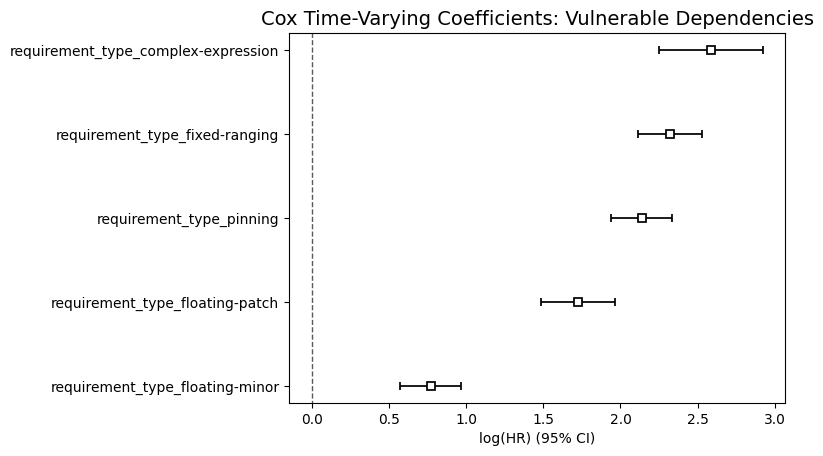

In [22]:
from lifelines import CoxTimeVaryingFitter
# Select a subset of variables
cols_to_keep = ['dependency_id', 'interval_start_days', 'interval_end_days', 'is_exposed',
    'requirement_type_floating-minor',
    'requirement_type_floating-patch',
    'requirement_type_fixed-ranging',
    # 'requirement_type_floating-major',
    'requirement_type_pinning',
    'requirement_type_complex-expression',
    #'requirement_type_at-most'
    #'requirement_type_or-expression',
    #'requirement_type_not-expression'
]

df_model_vul = df[cols_to_keep]

df_model_vul.head()
ctv = CoxTimeVaryingFitter()
ctv.fit(df_model_vul, id_col="dependency_id", event_col="is_exposed", 
       start_col="interval_start_days", stop_col="interval_end_days",
       show_progress=True)
ctv.print_summary()

# Plot and set title
ax = ctv.plot()
ax.set_title("Cox Time-Varying Coefficients: Vulnerable Dependencies", fontsize=14)
plt.show()

### Why does the model converge when we include complex expression but fail when we include at-most?

In [25]:
# Check the complete distribution of ALL requirement types
req_cols = [col for col in df.columns if col.startswith('requirement_type_')]
print("=== Distribution of ALL requirement types ===")
for col in req_cols:
    count = df[col].sum()
    events = df[df[col] == 1]['is_exposed'].sum()
    rate = events / count * 100 if count > 0 else 0
    print(f"{col}: {count:,} obs, {events} events ({rate:.3f}%)")

# Check if there are subjects with NO requirement type
df['any_requirement'] = df[[col for col in df.columns if col.startswith('requirement_type_')]].sum(axis=1)
print(f"\nSubjects with NO requirement type: {(df['any_requirement'] == 0).sum():,}")
print(f"Subjects with MULTIPLE requirement types: {(df['any_requirement'] > 1).sum():,}")

=== Distribution of ALL requirement types ===
requirement_type_floating-minor: 596,301 obs, 647 events (0.109%)
requirement_type_floating-patch: 62,809 obs, 155 events (0.247%)
requirement_type_fixed-ranging: 93,678 obs, 381 events (0.407%)
requirement_type_pinning: 199,152 obs, 584 events (0.293%)
requirement_type_complex-expression: 6,851 obs, 48 events (0.701%)
requirement_type_at-most: 4,116 obs, 115 events (2.794%)
requirement_type_or-expression: 2,283 obs, 0 events (0.000%)
requirement_type_not-expression: 989 obs, 1 events (0.101%)

Subjects with NO requirement type: 241,023
Subjects with MULTIPLE requirement types: 0


In [31]:
# Check baseline event rate (no requirement type)
baseline_events = df[df['any_requirement'] == 0]['is_exposed'].sum()
baseline_obs = (df['any_requirement'] == 0).sum()
baseline_rate = baseline_events / baseline_obs * 100

print(f"Baseline (no requirement) event rate: {baseline_rate:.3f}%")
print(f"at-most relative risk: {2.794 / baseline_rate:.1f}x baseline")
print(f"complex-expression relative risk: {0.701 / baseline_rate:.1f}x baseline")

Baseline (no requirement) event rate: 0.000%
at-most relative risk: infx baseline
complex-expression relative risk: infx baseline


/var/folders/6f/wmsnc89s2tn1gpcjgm2rbtjr0000gn/T/ipykernel_60021/2378773511.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"at-most relative risk: {2.794 / baseline_rate:.1f}x baseline")
/var/folders/6f/wmsnc89s2tn1gpcjgm2rbtjr0000gn/T/ipykernel_60021/2378773511.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"complex-expression relative risk: {0.701 / baseline_rate:.1f}x baseline")


In [21]:
requirement_vars = ['requirement_type_floating-minor', 'requirement_type_floating-patch', 
                   'requirement_type_fixed-ranging', 'requirement_type_pinning',
                   'requirement_type_complex-expression', 'requirement_type_at-most']

corr_matrix = df[requirement_vars].corr()
print("=== Correlation Matrix ===")
print(corr_matrix.round(3))

# Specifically check correlations with the two problematic variables
print("\n=== Correlations with complex-expression ===")
print(corr_matrix['requirement_type_complex-expression'].round(3))

print("\n=== Correlations with at-most ===") 
print(corr_matrix['requirement_type_at-most'].round(3))

=== Correlation Matrix ===
                                     requirement_type_floating-minor  \
requirement_type_floating-minor                                1.000   
requirement_type_floating-patch                               -0.231   
requirement_type_fixed-ranging                                -0.287   
requirement_type_pinning                                      -0.439   
requirement_type_complex-expression                           -0.075   
requirement_type_at-most                                      -0.058   

                                     requirement_type_floating-patch  \
requirement_type_floating-minor                               -0.231   
requirement_type_floating-patch                                1.000   
requirement_type_fixed-ranging                                -0.068   
requirement_type_pinning                                      -0.104   
requirement_type_complex-expression                           -0.018   
requirement_type_at-most            

Removing 'requirement_type_or-expression' from the df for is_exposed target event since 'requirement_type_or-expression' is too deterministic to predict 'is_exposed'.

Error from the fit function:

/home/imranur/security-metrics/secmet_venv/lib/python3.12/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column requirement_type_or-expression have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['is_exposed'].astype(bool)
>>> print(df.loc[events, 'requirement_type_or-expression'].var())
>>> print(df.loc[~events, 'requirement_type_or-expression'].var())

A very low variance means that the column requirement_type_or-expression completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.


...



ValueError: array must not contain infs or NaNs
...
    427                     raise e

ConvergenceError: hessian or gradient contains nan or inf value(s). Convergence halted. Please see the following tips in the lifelines documentation:
https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
array must not contain infs or NaNs

nans: 
dependency_id                          0
interval_start_days                    0
interval_end_days                      0
is_exposed                             0
requirement_type_floating-minor        0
requirement_type_floating-patch        0
requirement_type_fixed-ranging         0
requirement_type_pinning               0
requirement_type_complex-expression    0
requirement_type_at-most               0
requirement_type_not-expression        0
dtype: int64
infs: 
dependency_id          0
interval_start_days    0
interval_end_days      0
dtype: int64
unique values: 
dependency_id                          16094
interval_start_days                     4413
interval_end_days                       4434
is_exposed                                 2
requirement_type_floating-minor            2
requirement_type_floating-patch            2
requirement_type_fixed-ranging             2
requirement_type_pinning                   2
requirement_type_complex-expression        2
requirement_t

/home/imranur/security-metrics/secmet_venv/lib/python3.12/site-packages/lifelines/fitters/cox_time_varying_fitter.py:488: ConvergenceWarning: Newton-Raphson convergence completed but norm(delta) is still high, 0.691. This may imply non-unique solutions to the maximum likelihood. Perhaps there is colinearity or complete separation in the dataset?
  warnings.warn(


<lifelines.CoxTimeVaryingFitter: fitted with 1207202 periods, 16094 subjects, 1931 events>
         event col = 'is_exposed'
number of subjects = 16094
 number of periods = 1207202
  number of events = 1931
partial log-likelihood = -16090.88
  time fit was run = 2025-05-25 20:24:42 UTC

---
                                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                            
requirement_type_floating-minor     24.25  3.40e+10   7268.76       -14222.25        14270.75                0.00                 inf
requirement_type_floating-patch     25.20  8.81e+10   7268.76       -14221.30        14271.70                0.00                 inf
requirement_type_fixed-ranging      25.79  1.59e+11   7268.76       -14220.71        14272.30                0.00                 inf
requirement_type_pinning            25.62  1.33e+11   7268.76       -14220.88        14272.12                0.00                 inf
requirement_type_complex-expression 26.05  2.05e+11   7268.76       -14220.45        14272.55                0.00                 inf
requirement_type_at-most            27.55  9.18e+11   7268.76       -14218.95        14274.05                0.00                 inf
requirement_type_not-expression     23.99  2.62e+10   7268.76       -14222.51        14270.49                0.00                 inf

                                     cmp to    z    p  -log2(p)
covariate                                                      
requirement_type_floating-minor        0.00 0.00 1.00      0.00
requirement_type_floating-patch        0.00 0.00 1.00      0.00
requirement_type_fixed-ranging         0.00 0.00 1.00      0.00
requirement_type_pinning               0.00 0.00 1.00      0.00
requirement_type_complex-expression    0.00 0.00 1.00      0.00
requirement_type_at-most               0.00 0.00 1.00      0.00
requirement_type_not-expression        0.00 0.00 1.00      0.00
---
Partial AIC = 32195.76
log-likelihood ratio test = 2146.21 on 7 df
-log2(p) of ll-ratio test = inf

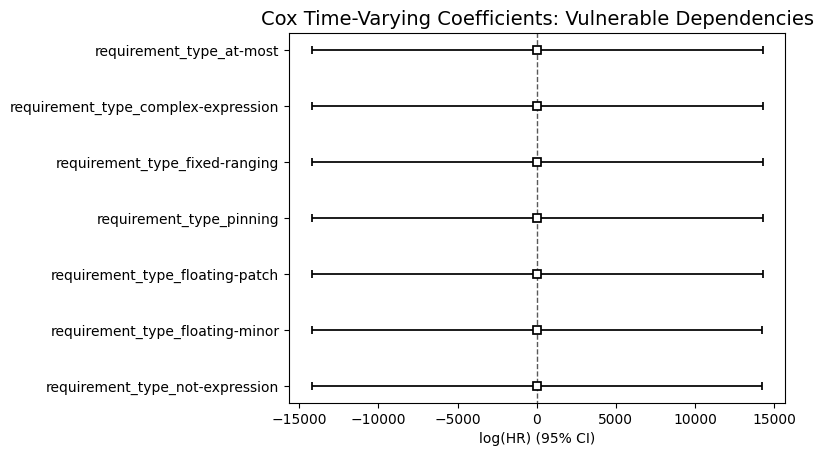

In [16]:
# Select a subset of variables
cols_to_keep = ['dependency_id', 'interval_start_days', 'interval_end_days', 'is_exposed',
    'requirement_type_floating-minor',
    'requirement_type_floating-patch',
    'requirement_type_fixed-ranging',
    # 'requirement_type_floating-major',
    'requirement_type_pinning',
    'requirement_type_complex-expression',
    'requirement_type_at-most',
    # 'requirement_type_or-expression',
    'requirement_type_not-expression'
]

df_model_reduced = df_model_vuln[cols_to_keep]

# I added this to do some checking
# Check for NaNs
print("nans: ")
print(df_model_reduced.isnull().sum())

# Check for Infs
print("infs: ")
print(np.isinf(df_model_reduced.select_dtypes(include=[np.number])).sum())

print("unique values: ")
print(df_model_reduced.nunique())  # Columns with only one unique value
print("correlations: ")
print(df_model_reduced.corr())     # Check for high correlation
# Turns out the step_size was too large, so I reduced it to 0.1


ctv = CoxTimeVaryingFitter()
ctv.fit(df_model_reduced, id_col="dependency_id", event_col="is_exposed", 
       start_col="interval_start_days", stop_col="interval_end_days",
       show_progress=True, fit_options={"step_size": 0.1})
ctv.print_summary()

# Plot and set title
ax = ctv.plot()
ax.set_title("Cox Time-Varying Coefficients: Vulnerable Dependencies", fontsize=14)
plt.show()

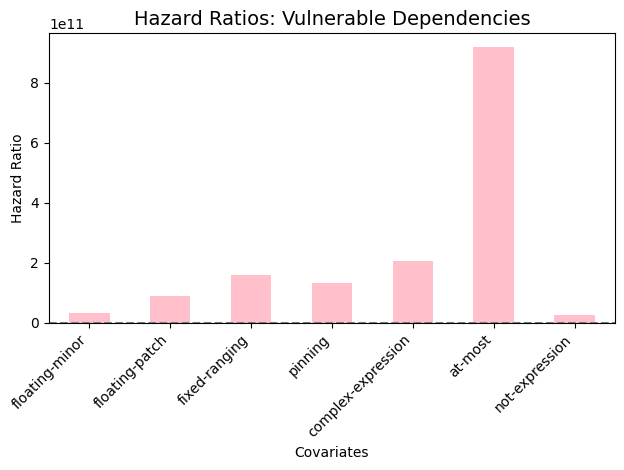

In [17]:
# Plot hazard ratios instead of coefficients
# Define your renaming dictionary
rename_map = {
    'requirement_type_floating-minor': 'floating-minor',
    'requirement_type_floating-patch': 'floating-patch',
    'requirement_type_fixed-ranging': 'fixed-ranging',
    'requirement_type_floating-major': 'floating-major',
    'requirement_type_pinning': 'pinning',
    'requirement_type_complex-expression': 'complex-expression',
    'requirement_type_at-most': 'at-most',
    # 'requirement_type_or-expression': 'or-expression',
    'requirement_type_not-expression': 'not-expression',
}

# Get hazard ratios
hazard_ratios = np.exp(ctv.params_)

# Plot hazard ratios
ax = hazard_ratios.plot(kind='bar', color = 'pink')

# Apply renaming just to x-axis labels
new_labels = [rename_map.get(label, label) for label in hazard_ratios.index]
ax.set_xticklabels(new_labels, rotation=45, ha='right')

# Set plot details
ax.set_title("Hazard Ratios: Vulnerable Dependencies", fontsize=14)
ax.set_ylabel("Hazard Ratio")
ax.set_xlabel("Covariates")
plt.axhline(y=1, color='grey', linestyle='--')
plt.tight_layout()
plt.show()